## Random Forest From Scratch - Oded Ben Chetrit

In this Project I will implement a Random forest regressor from scratch

  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest

* The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples

* To check your random forest implementation, I used the boston dataset (`from sklearn.datasets import load_boston`)


In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, min_leaf = None, n_features = None):
        self.X = X
        self.y = y
        self.n_trees = n_trees
        self.sample_sz = sample_sz
        self.n_features = n_features 
        self.min_leaf = min_leaf
        self.tree_dic = {}
        
    # creating the bootstrap:
    def create_bootstrap(self):

        # obtain data sample size:
        n_samples = self.X.shape[0]

        # Randomly select row indecies - bootstrap data with replacement
        index = np.random.randint(0, n_samples, self.sample_sz)

        # find the unique rows indecies selected
        unique_index = np.unique(index)

        # create an array of all row indecies of the original data
        tot_index = np.arange(n_samples)

        # Define the oob indecies as the indecies of the original data that were not selected in the bootstrap
        oob_index = tot_index[~np.isin(tot_index, unique_index)]

        # Create bootstrap data using the bootstrap indecies
        X_bootstraped = self.X[index]
        y_bootstraped = self.y[index]

        # Create oob data using oob indecies:
        X_oob = self.X[oob_index]
        y_oob = self.y[oob_index]

        return X_bootstraped, y_bootstraped, X_oob, y_oob
    
    def fit(self):
        
        # Create The Random Forest by creating n_trees Decision trees with bootstraped data:
        for i in range(self.n_trees):
            
            # Creating a bootstrap data: 
            X_bootstraped, y_bootstraped, X_oob, y_oob = self.create_bootstrap()
            
            # Define Decision Tree:
            DT = DecisionTreeRegressor(max_features = self.n_features, min_samples_leaf = self.min_leaf)
            
            # Fit Decision Tree:
            DT.fit(X_bootstraped, y_bootstraped)
            
            # Compute oob predictions for later use.. 
            y_oob_hat = DT.predict(X_oob)
            
            # Store model and oob in a dictionary:
            self.tree_dic[i] = {'model' : DT, 'y_oob': y_oob, 'y_oob_hat' : y_oob_hat}
          
    def predict(self, X):
        
        # Initialize a matrix of prediction with size [n_samples x n_trees]
        y_preds_matrix = np.zeros([X.shape[0], self.n_trees])
        
        # Run over all trees and predict y_hat for each tree, store in the matrix
        for i in range(self.n_trees):
            DT = self.tree_dic[i]['model']
            y_preds_matrix[:,i] = DT.predict(X)
            
        # Compute the mean prediction from all trees for each sample: 
        return np.mean(y_preds_matrix, axis = 1)

    def oob_mse(self):
        
        # Run over all oob of each tree and compute it's MSE
        mse = [mean_squared_error(self.tree_dic[i]['y_oob'], self.tree_dic[i]['y_oob_hat']) for i in range(self.n_trees)]
        
        # Return the mean mse 
        return np.mean(mse)
    
    def score(self, X, y):
        
        # Compute y_preds:
        y_preds = self.predict(X)
        
        # Calculate mse of y and y_preds:
        return mean_squared_error(y, y_preds)

In [2]:
# import data
from sklearn.datasets import load_boston

data = load_boston()
X = data['data']
Y = data['target']

best_mse = np.inf

for n in [1,5,10,20,50,100]:
    for sz in [50,100,300,500]:
        for min_leaf in [1,5]:
            forest = TreeEnsemble(X, Y, n, sz, min_leaf)
            forest.fit()
            mse = forest.oob_mse()
            if mse < best_mse:
                best_mse = mse
                best_params = {'n': n, 'sz': sz, 'min_leaf': min_leaf}
            print(f'With n trees = {n}, sample size = {sz} and min leaf = {min_leaf} the OOB - MSE is: {mse}')
                
print(f'Best params are: {best_params} with OOB - MSE : {best_mse}')

With n trees = 1, sample size = 50 and min leaf = 1 the OOB - MSE is: 34.14021691973969
With n trees = 1, sample size = 50 and min leaf = 5 the OOB - MSE is: 28.8900058685874
With n trees = 1, sample size = 100 and min leaf = 1 the OOB - MSE is: 32.922518159806295
With n trees = 1, sample size = 100 and min leaf = 5 the OOB - MSE is: 35.44040368097105
With n trees = 1, sample size = 300 and min leaf = 1 the OOB - MSE is: 22.316401384083047
With n trees = 1, sample size = 300 and min leaf = 5 the OOB - MSE is: 29.66745424863717
With n trees = 1, sample size = 500 and min leaf = 1 the OOB - MSE is: 19.58513089005236
With n trees = 1, sample size = 500 and min leaf = 5 the OOB - MSE is: 14.12247143357549
With n trees = 5, sample size = 50 and min leaf = 1 the OOB - MSE is: 37.11554482817987
With n trees = 5, sample size = 50 and min leaf = 5 the OOB - MSE is: 35.10965024440881
With n trees = 5, sample size = 100 and min leaf = 1 the OOB - MSE is: 30.201717711450947
With n trees = 5, sampl

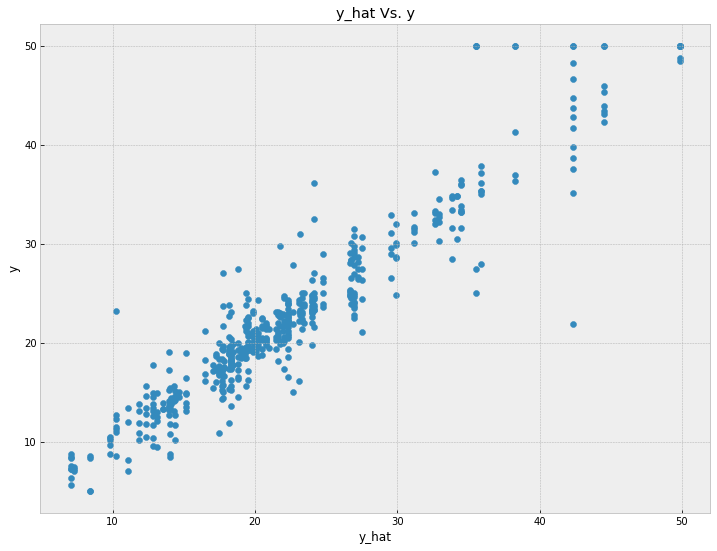

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use("bmh")

# Define model with best params: 
forest = TreeEnsemble(X, Y, best_params['n'], best_params['sz'], best_params['min_leaf'])

# fit and predict model:
forest.fit()
y_hat = forest.predict(X)  

# plot scatter plot:
plt.figure(figsize = (12,9))
plt.scatter(y_hat, Y)
plt.title('y_hat Vs. y')
plt.xlabel('y_hat')
plt.ylabel('y')
plt.show()